In [26]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torch.nn.functional as F
import numpy as np
import pandas as pd
import math as math
import matplotlib.pyplot as plt
import os

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device {device}')

Using device cpu


In [28]:
# Data Loading
DATA_PATH = "data/"
TRAIN_PATH = DATA_PATH + "train.csv"
TEST_PATH = DATA_PATH + "test.csv"
TRAIN_TEST_SPLIT = (0.85, 0.15)

# Data & Augmentation
IMAGE_SIZE = 28
ROTATION_RANGE = 15
ZOOM_RANGE = (0.9, 1.1)
TRANSLATE_RANGE = (0.2, 0.2)
NUM_CLASSES = 10

# Model 
MODEL_VERSION = "v1"

# Training
BATCH_SIZE = 50
NUM_EPOCHS = 100
PATIENCE = 5
LEARNING_RATE = 3e-4

# Saving/Loading Model + Testing
MODEL_PATH = "model/"
MODEL_SAVE_PATH = MODEL_PATH + MODEL_VERSION + "/"
MODEL_NAME = "model.pt"
OUTPUT_PATH = "output/"
OUTPUT_FILENAME = "my_submission_cnn_augmentation_batch_size_50_maxepochs_100_batchnorm_dropout_v1.csv"

In [29]:
os.makedirs(DATA_PATH, exist_ok=True)
os.makedirs(MODEL_PATH, exist_ok=True)
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)
os.makedirs(OUTPUT_PATH, exist_ok=True)

In [30]:
class DigitsDataset(Dataset):
    AUGMENT = torchvision.transforms.RandomAffine(ROTATION_RANGE, translate=TRANSLATE_RANGE, scale=ZOOM_RANGE)
    
    def __init__(self, augment=False, csv_path=None, subset=None):
        self.subset = subset
        self.augment = augment

        if (not self.subset):
            self.raw_csv = pd.read_csv(csv_path)
    
    def __getitem__(self, index):
        image, label = None, None

        if(self.subset):
            image, label = self.subset[index]
        else:
            image = torch.tensor(self.raw_csv.iloc[index, 1:]).reshape(-1,IMAGE_SIZE,IMAGE_SIZE).to(torch.float32) # 1 x 28 x 28
            label = F.one_hot(torch.tensor(self.raw_csv.iloc[index, 0]), num_classes=NUM_CLASSES).to(torch.float32) # 1 x 10

        if(self.augment):
            image = DigitsDataset.AUGMENT(image)
            
        return (image, label)
    
    def __len__(self):
        
        if(self.subset):
            return len(self.subset)
        else:   
            return len(self.raw_csv)

    def set_augment(self, augment):
        self.augment = augment
    
    
    

In [31]:
class ConvNeuralNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(5,5), stride=1, padding=2)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(2,2))
        self.batch_norm3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(128*3*3, 200)
        self.fc2 = nn.Linear(200, self.num_classes)

    
    def forward(self, x):
        out = x # 1 x 28 x 28
        out = F.relu(self.conv1(x)) # 1 x 32 x 28 x 28
        out = self.batch_norm1(out)
        out = self.pool(out) # 1 x 32 x 14 x 14
        out = F.relu(self.conv2(out)) # 1 x 64 x 14 x 14 
        out = self.batch_norm2(out)
        out = self.pool(out) # 1 x 64 x 7 x 7
        out = F.relu(self.conv3(out)) # 1 x 128 x 6 x 6
        out = self.batch_norm3(out)
        out = self.pool(out) # 1 x 128 x 3 x 3
        out = out.reshape(-1, 128*3*3) # 1 x 1152
        out = F.relu(self.fc1(out)) # 1 x 200
        out = self.dropout(out)
        out = self.fc2(out) # 1 x 10 
        return out

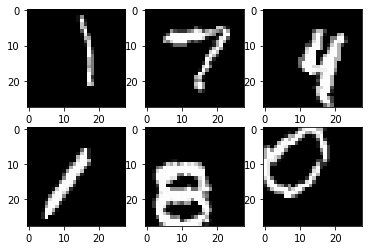

In [32]:
all_set = DigitsDataset(csv_path=TRAIN_PATH)
train_split_set, val_split_set = random_split(all_set, [int(len(all_set) * TRAIN_TEST_SPLIT[0]), int(len(all_set) * TRAIN_TEST_SPLIT[1])])

train_set = DigitsDataset(augment=True, subset=train_split_set)
val_set = DigitsDataset(augment=False, subset=val_split_set)


train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=BATCH_SIZE, shuffle=False)

train_iter = iter(train_loader)
samples, _ = next(train_iter)

for i in range(6):
    plt.subplot(2,3, i+1)
    plt.imshow(samples[i][0], cmap="gray")
plt.show()


In [33]:
model = ConvNeuralNet(NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
n_total_batches = len(train_loader)
n_total_val_batches = len(val_loader)
epoch_avg_train_loss_list = []
epoch_avg_val_acc_list = []
curr_avg_val_acc = 0
patience = 0

for epoch in range(NUM_EPOCHS):
    model.eval()
    new_avg_val_acc = 0
    total_correct = 0
    
    with torch.no_grad():

        for i, (samples, labels) in enumerate(val_loader):
            samples = samples.to(device)
            outputs = model(samples)
            predicted_digits = torch.max(outputs, 1).indices
            actual_digits = torch.max(labels, 1).indices
            total_correct += (predicted_digits == actual_digits).sum().item()
    new_avg_val_acc = total_correct / (n_total_val_batches * BATCH_SIZE)
    epoch_avg_val_acc_list.append(new_avg_val_acc)

    if (new_avg_val_acc >= curr_avg_val_acc or patience < PATIENCE):

        if (new_avg_val_acc >= curr_avg_val_acc):
            patience = 0
            curr_avg_val_acc = new_avg_val_acc
            torch.save(model.state_dict(), MODEL_SAVE_PATH + MODEL_NAME)
        else:
            patience += 1
    else:
        
        if (patience >= PATIENCE):
            break

    model.train()
    epoch_avg_train_loss = 0

    for i, (samples, labels) in enumerate(train_loader):
        samples = samples.to(device)
        outputs = model(samples)
        loss = criterion(outputs, labels)
        epoch_avg_train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    epoch_avg_train_loss = epoch_avg_train_loss / n_total_batches
    epoch_avg_train_loss_list.append(epoch_avg_train_loss)
    print(f'Epoch {epoch+1}, Average Training Loss: {epoch_avg_train_loss:.4f}, Average Validation Accuracy: {new_avg_val_acc:.4f}')




Epoch 1, Average Training Loss: 0.4140, Average Validation Accuracy: 0.1267
Epoch 2, Average Training Loss: 0.1364, Average Validation Accuracy: 0.9786
Epoch 3, Average Training Loss: 0.0985, Average Validation Accuracy: 0.9805
Epoch 4, Average Training Loss: 0.0817, Average Validation Accuracy: 0.9860
Epoch 5, Average Training Loss: 0.0786, Average Validation Accuracy: 0.9821
Epoch 6, Average Training Loss: 0.0708, Average Validation Accuracy: 0.9878
Epoch 7, Average Training Loss: 0.0649, Average Validation Accuracy: 0.9900
Epoch 8, Average Training Loss: 0.0586, Average Validation Accuracy: 0.9910
Epoch 9, Average Training Loss: 0.0577, Average Validation Accuracy: 0.9889
Epoch 10, Average Training Loss: 0.0562, Average Validation Accuracy: 0.9890
Epoch 11, Average Training Loss: 0.0496, Average Validation Accuracy: 0.9900
Epoch 12, Average Training Loss: 0.0522, Average Validation Accuracy: 0.9903
Epoch 13, Average Training Loss: 0.0477, Average Validation Accuracy: 0.9911
Epoch 14

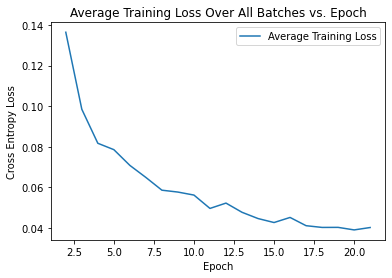

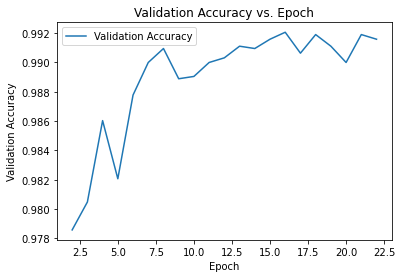

In [34]:
plt.figure()
plt.title("Average Training Loss Over All Batches vs. Epoch")
plt.ylabel("Cross Entropy Loss")
plt.xlabel("Epoch")
plt.plot([i+1 for i in range(len(epoch_avg_train_loss_list))][1:], epoch_avg_train_loss_list[1:], label="Average Training Loss")
plt.legend()
plt.show()

plt.figure()
plt.title("Validation Accuracy vs. Epoch")
plt.ylabel("Validation Accuracy")
plt.xlabel("Epoch")
plt.plot([i+1 for i in range(len(epoch_avg_val_acc_list))][1:], epoch_avg_val_acc_list[1:], label="Validation Accuracy")
plt.legend()
plt.show()

2


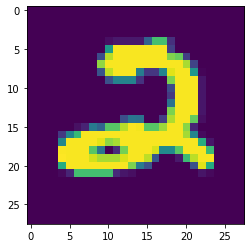

0


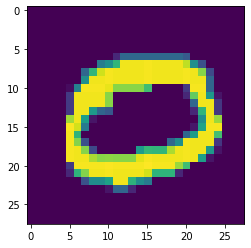

9


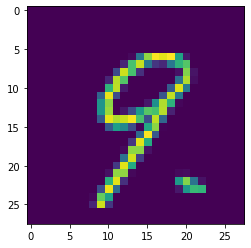

0


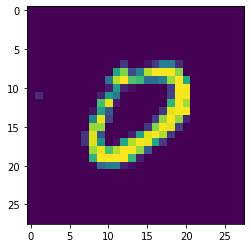

3


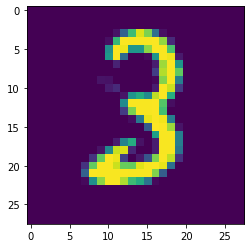

7


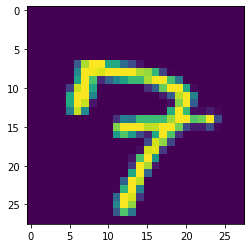

0


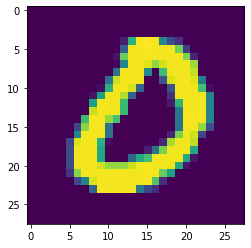

3


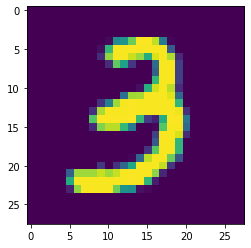

0


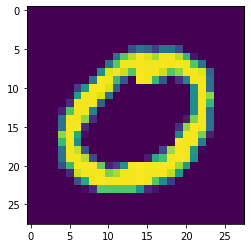

3


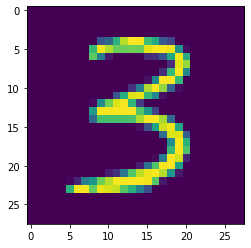

5


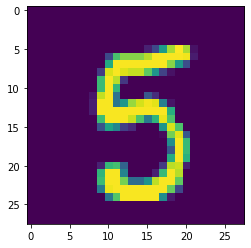

7


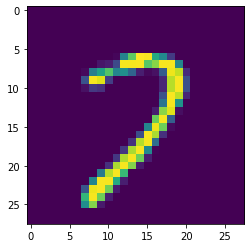

4


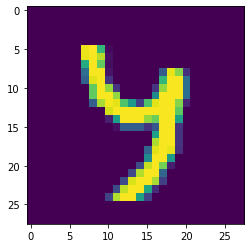

0


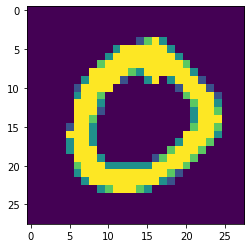

4


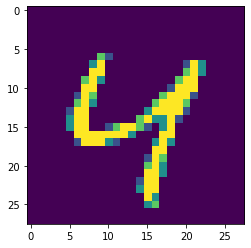

3


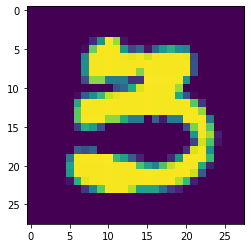

3


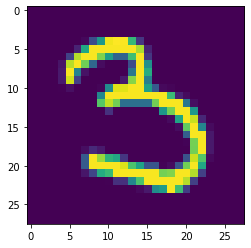

1


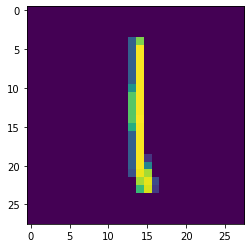

9


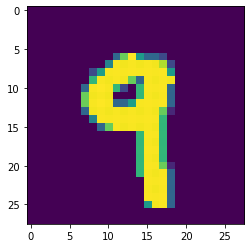

0


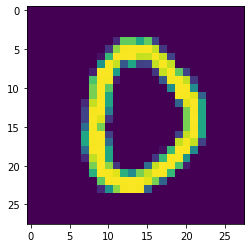

In [35]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency
test_model = ConvNeuralNet(NUM_CLASSES).to(device)
test_model.load_state_dict(torch.load(MODEL_SAVE_PATH + MODEL_NAME))
test_model.eval()

test_csv = pd.read_csv(TEST_PATH)
N = len(test_csv)
predict_df = pd.DataFrame(columns=['ImageId','Label'])

with torch.no_grad():

    for i in range(N):
        image = torch.tensor(test_csv.iloc[i, :]).reshape(1,1,IMAGE_SIZE,IMAGE_SIZE).to(torch.float32).to(device)
        predicted_digit = torch.max(test_model(image), 1).indices.item()

        if (i+1 <= 20):
            print(predicted_digit)
            plt.figure()
            plt.imshow(image[0][0])
            plt.show()
            
        predict_df = predict_df.append({'ImageId': i+1, 'Label': predicted_digit}, ignore_index=True)

In [36]:
predict_df.to_csv(OUTPUT_PATH + OUTPUT_FILENAME, index=False)